In [93]:
import gensim
from gensim.corpora import Dictionary
from gensim.models import LsiModel
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
import itertools
import json
from nltk.tokenize import word_tokenize
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import pairwise_distances
import pickle

In [94]:
'''
Load a json file into a dictionary

Input: 
    - file_path: path to json file containing dataset

Returns: 
    - 
'''
def load_json(file_path): 
    with open(file_path, 'r') as f: 
        data = json.load(f)
    return data



In [95]:
'''
build a dataset using tropes 

Inputs: 
    - data: dictionary mapping titles to list of tropes

Returns: 
    - dictionary: a bag of words dictionary representation tropes 
    - tf_idf: tf-idf model of dictionary
    - similarity_matrix: cosine similarity matrix of entries in dataset
'''
def build_representation_for_tropes(data): 
    
    # build corpus of titles that contain field 
    corpus = []
    for title, tropes in data.items(): 
        corpus.append([word.lower() for word in itertools.chain.from_iterable([re.findall('[A-Z][^A-Z]*', trope) for trope in tropes])])
            
    print('{} titles'.format(len(corpus)))
        
    # build dictionary from corpus
    dictionary = Dictionary(corpus)
    # convert entries to bag of words representation
    corpus = [dictionary.doc2bow(entry) for entry in corpus]
    # create tf-idf model
    tf_idf = gensim.models.TfidfModel(corpus)
    # compute similarity matrix
    similarity_matrix = gensim.similarities.Similarity('', tf_idf[corpus], num_features = len(dictionary))
    
    return dictionary, tf_idf, similarity_matrix


In [96]:
'''
Returns the k words closest to the keyword in the list 

Inputs: 
    - keyword: the keyword to search
    - dictionary: dictionary of trope words in dataset to search against 
    - model: the pretrained gensim model
    - top_k: number of words to return

Returns: 
    - sorted_keyword_match: list of the k words that are closest to the keyword
'''
def get_closest_to_keyword(keyword, dictionary, model, top_k = 5): 
    
    # compute cosine similarity between query and all trope words
    all_words = list(dictionary.values())
    all_words = [word for word in all_words if word in model.wv.vocab]
    dists = model.distances(keyword, all_words)
    
    # sort by similarity in ascending order (0 = perfect similarity)
    sorted_indices = np.argsort(dists)
    sorted_keyword_match = [all_words[idx] for idx in sorted_indices[:top_k]]
    
    print('top {} matches most similar to `{}`'.format(top_k, keyword))
    for word in sorted_keyword_match: 
        print(word)
        
    return sorted_keyword_match
    

In [205]:
'''
Finds the best titles according to tropes based on an input title and keyword. 
The trope words of the title being searched and the trope words most similar to 
the keyword are used to find the best matches. 

Inputs: 
    - title: the title being queried
    - title_dataset: the dataset corresponding to the title (eg. book dataset if book title)
    - keyword: the keyword to search
    - dictionary: dictionary representation of genres associated with each title of desired return type
    - tf_idf: tf-idf representation of genres associated with each title of desired return type
    - similarity_matrix: similarity matrix according to tf-idf representation 
    - model: the pretrained gensim model
    - top_k_tropes: number of tropes to use when querying
    
Reutrns: 
    - scores: numpy array of similarity scores in where the index in the array corresponds
              to the index in the dataset of the media type being recommended
'''
def best_titles_by_tropes_enhanced(title, title_dataset, keyword, dictionary, tf_idf, similarity_matrix, model, top_k_tropes = 5): 
    
    # get list of most similar trope words to keyword
    most_similar_tropes = get_closest_to_keyword(keyword, dictionary, model, top_k_tropes)
    # also take tropes of title into account
    title_tropes = [word.lower() for word in set(itertools.chain.from_iterable([re.findall('[A-Z][^A-Z]*', trope) for trope in title_dataset[title]]))]
    most_similar_tropes.extend(title_tropes)
    
    # convert query to bag of words representation
    query_bow = dictionary.doc2bow(most_similar_tropes)
    # create tf-idf model of query 
    query_tf_idf = tf_idf[query_bow]
    
    # get indices of most similar title indices to query (descending similarity)
    scores = similarity_matrix[query_tf_idf]
    
    return scores


In [206]:
def print_results(title, keyword, scores, results_data, top_k_titles = 10): 
    
    # sort the scores in descending order
    ranked_indices = np.argsort(scores)[::-1]
    
    # get list of titles
    titles = list(results_data.keys())

    print('\ntop {} most similar titles to `{}` by trope to keyword `{}` '.format(top_k_titles, title, keyword))
    for idx in range(top_k_titles): 
        print((scores[ranked_indices[idx]], titles[ranked_indices[idx]]))
    

In [207]:
# load pretrained word embeddings
model = KeyedVectors.load_word2vec_format('app/irsystem/controllers/DatasetInfo/gensim_glove.6B.50d.txt', binary = False, limit=50000)

In [208]:
# load book and movie datasets
with open("./app/irsystem/controllers/TVTropesScraper/Film/Film_tropes_dataset3.json", 'r') as f:
    movies = json.load(f)
with open("./app/irsystem/controllers/TVTropesScraper/Literature/Literature_tropes_dataset3.json", 'r') as f:
    books = json.load(f)

In [209]:
# create dictionary representations of datasets
book_dictionary, book_tf_idf, book_similarity_matrix = build_representation_for_tropes(books)
movie_dictionary, movie_tf_idf, movie_similarity_matrix = build_representation_for_tropes(movies)

2933 titles
4797 titles


In [161]:
print('zombies' in set(dict(book_dictionary).values()))
print('zombies' in set(dict(movie_dictionary).values()))

True
True


In [124]:
book_similarity_matrix

In [166]:
book_tf_idf.save("./app/irsystem/controllers/SPARSE OR NECESSARY/book_tf_idf.p")
book_dictionary.save("./app/irsystem/controllers/SPARSE OR NECESSARY/book_dictionary.p")
book_similarity_matrix.save("./app/irsystem/controllers/SPARSE OR NECESSARY/book_similarity_matrix.p")
movie_tf_idf.save("./app/irsystem/controllers/SPARSE OR NECESSARY/movie_tf_idf.p")
movie_dictionary.save("./app/irsystem/controllers/SPARSE OR NECESSARY/movie_dictionary.p")
movie_similarity_matrix.save("./app/irsystem/controllers/SPARSE OR NECESSARY/movie_similarity_matrix.p")
model.save("./app/irsystem/controllers/SPARSE OR NECESSARY/model.p")

In [174]:
book_tf_idf = pickle.load(open("./app/irsystem/controllers/SPARSE OR NECESSARY/book_tf_idf.p", "rb" ))
book_dictionary = pickle.load(open("./app/irsystem/controllers/SPARSE OR NECESSARY/book_dictionary.p", "rb" ))
book_similarity_matrix = pickle.load(open("./app/irsystem/controllers/SPARSE OR NECESSARY/book_similarity_matrix.p", "rb" ))
movie_tf_idf = pickle.load(open("./app/irsystem/controllers/SPARSE OR NECESSARY/movie_tf_idf.p", "rb" ))
movie_dictionary = pickle.load(open("./app/irsystem/controllers/SPARSE OR NECESSARY/movie_dictionary.p", "rb" ))
movie_similarity_matrix = pickle.load(open("./app/irsystem/controllers/SPARSE OR NECESSARY/movie_similarity_matrix.p", "rb" ))
model = pickle.load(open("./app/irsystem/controllers/SPARSE OR NECESSARY/model.p", "rb" ))

In [114]:
model

In [116]:
all_words = list(book_dictionary.values())


In [117]:
all_words = [word for word in all_words if word in model.wv.vocab]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """Entry point for launching an IPython kernel.


In [210]:
'''
FULL SEARCH ALGORITHM TO USE IN FINAL PROJECT. This returns a numpy array of similarity scores
for a title + keyword query

Inputs: 
     - title: the title being queried
     - keyword: the keyword being queried
     - direction: either 'book to movie' or 'movie to book' 

Returns: 
     - similarity_scores: numpy array of similarity scores where the index in the array 
                          corresponds to the index in the 'to' dataset (ie. if the query
                          direction was book to movie, the indices would correspond to the 
                          indices in the movie tropes dataset)
'''
def full_search(title, keyword, direction):
    
    # number of tropes to use to incorporate the keyword
    top_k_tropes = 5
    
    if direction == 'book to movie': 
        title_dataset = books
        dictionary = movie_dictionary
        tf_idf = movie_tf_idf
        similarity_matrix = movie_similarity_matrix
    else: # movie to book
        title_dataset = movies
        dictionary = book_dictionary
        tf_idf = book_tf_idf
        similarity_matrix = book_similarity_matrix
           
    similarity_scores = best_titles_by_tropes_enhanced(title, title_dataset, keyword, dictionary, tf_idf, similarity_matrix, model, top_k_tropes)

    return similarity_scores
    
    

In [211]:
# example query 
scores = full_search('Romeo And Juliet', 'gun', 'book to movie')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


top 5 matches most similar to `gun`
gun
guns
assault
weapon
rifle
['gun', 'guns', 'assault', 'weapon', 'rifle']
['gun', 'guns', 'assault', 'weapon', 'rifle', 'dissonance', 'retreat', 'dies', 'relationship', 'parallel', 'ghost', 'aesop', 'dead', 'bonus', 'masquerade', 'gunman', 'plucky', 'punch', 'thin', 'guy', 'instigator', 'tu', 'doing', 'weapon', 'hair', 'die', 'remind', 'confession', 'et', 'knight', 'flasks', 'grey', 'euphemism', 'osmosis', 'brute', 'maid', 'roaring', 'reliable', 'reveal', 'did', 'hot', 'charmless', 'you', 'mortal', 'narcissist', 'bromantic', 'and', 'poor', 'runaway', 'horribly', 'boast', 'pungeon', 'serial', 'retribution', 'busting', 'fighting', 'i', 'cassandra', 'false', 'paper', 'old', 'dramatic', 'hypocrite', 'im', 'ex', 'double', 'women', 'villain', 'morality', 'enter', 'walk', 'clown', 'dark', 'mistake', 'suicide', 'troubled', 'can', 'part', 'idle', 'dropped', 'bridge', 'diabolus', 'sacrificial', 'antagonist', 'mandatory', 'different', 'envy', 'evil', 'adaptat

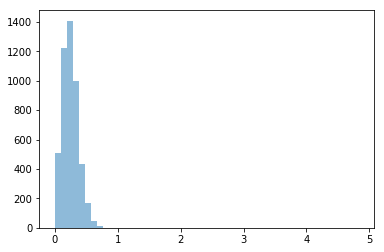

In [204]:
from matplotlib import pyplot as plt
%matplotlib inline

plt.hist(scores*5, bins=50, alpha=0.5)
plt.show()

In [164]:
# example to print nice list of ranked results 
print_results('', '', scores, movies, 10)


top 10 most similar titles to `` by trope to keyword `` 
(0.13669595, 'Fight Club')
(0.13626686, 'A Quiet Place')
(0.1338901, 'Raise the Red Lantern')
(0.13302472, 'Amores Perros')
(0.13059594, 'Southpaw')
(0.13056025, 'Shaolin Soccer')
(0.1292871, 'Mr. Smith Goes to Washington')
(0.12535769, 'Premonition')
(0.123279065, 'X-Men: First Class')
(0.12259054, "Mr. Popper's Penguins")
